In [1]:
%%html
<style>
    .dothis{
    font-weight: bold;
    color: #ff7f0e;
    font-size:large
    }
</style>

# Glacier mapping by means of band math

*****

This notebook demonstrates how we can use Python to do the same glacier mapping that we earlier carried out in QGIS.

There are several points at which you will need to modify a line of code. These are identified by <span class='dothis'>bold orange text</span>.


### Reading the data

We start with a few preparation such as reading all the packages we use in the processing.

In [2]:
# Import modules

# reload module before executing code
%load_ext autoreload
%autoreload 2

# define modules locations (you might have to adapt define_mod_locs.py)
%run ../sdc-notebooks/Tools/define_mod_locs.py

# import general libraries and allocate them a specific name
import time
import xarray as xr
import rioxarray
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# import specific functions from general libraries
from datetime import datetime
from IPython.display import Image, display, HTML
from matplotlib import colors

# Import UniFr customised geotiff utils
from geotiff_utilities import write_geotiff_from_xr

# to plot figures
%matplotlib inline

# connect to DC
import datacube
dc = datacube.Datacube()

# silence warning (not recommended during development)
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Change the size of the figures displayed in the notebooks: units are inches, order is (width, height).
plt.rcParams['figure.figsize'] = (16,8)      

**The next cell contains the dataset configuration information, which we have already made for you using the [config_tool](config_tool.ipynb) notebook. This ensures that you will have data well suited to map glacier extent.**

**To make this notebook run you will need to use anyone of Landsat or Sentinel 2 products with the red green and blue bands, as well as at least one swir band.**

In [4]:
# Configuration

product = 'landsat_ot_c2_l2'
measurements = ['QA_PIXEL', 'blue', 'green', 'red', 'nir', 'swir_1', 'swir_2']

longitude = (7.73228, 7.957461)
latitude = (45.877007, 46.022142)
crs = 'epsg:4326'

time = ('2016-08-01', '2016-09-30')
# the following date formats are also valid:
# time = ('2000-01-01', '2001-12-31')
# time=('2000-01', '2001-12')
# time=('2000', '2001')

output_crs = 'epsg:2056'
resolution = -30.0, 30.0

****

__In the following we are using `dc.load()` to load the data. In contrast to `lsc2_loadcleanscale()`, typically used in the other examples, 
this function does not mask any cloud covered areas.__

We are using `dc.load()` because the cloud masking does not work in the mountains where snow and ice get confused with clouds. 

**However, this means we now have to look at the scenes and manually decide which ones are cloud free.**

****

**If you see an error message when running the cell below, try running the configuration cell above again**

In [5]:
dataset_in = dc.load(product = product,
                     time = time, 
                     lon = longitude, 
                     lat = latitude,
                     measurements = measurements,
                     output_crs = output_crs, 
                     resolution = resolution)
dataset_in

<xarray.Dataset>
Dimensions:      (time: 7, y: 547, x: 590)
Coordinates:
  * time         (time) datetime64[ns] 2016-08-09T10:10:45 ... 2016-09-26T10:...
  * y            (y) float64 5.097e+06 5.097e+06 ... 5.081e+06 5.081e+06
  * x            (x) float64 4.016e+05 4.017e+05 ... 4.193e+05 4.193e+05
    spatial_ref  int32 32632
Data variables:
    QA_PIXEL     (time, y, x) uint16 1 1 1 1 1 ... 21824 21824 21824 21824 21824
    blue         (time, y, x) uint16 0 0 0 0 0 0 ... 9276 8390 9588 10283 10033
    green        (time, y, x) uint16 0 0 0 0 0 ... 11472 11010 12067 12422 12035
    red          (time, y, x) uint16 0 0 0 0 0 ... 11778 11233 12579 13025 12572
    nir          (time, y, x) uint16 0 0 0 0 0 ... 24049 26466 21705 19168 19308
    swir_1       (time, y, x) uint16 0 0 0 0 0 ... 21198 21123 21077 21087 20599
    swir_2       (time, y, x) uint16 0 0 0 0 0 ... 15591 14961 16309 17101 16666
Attributes:
    crs:           epsg:32632
    grid_mapping:  spatial_ref

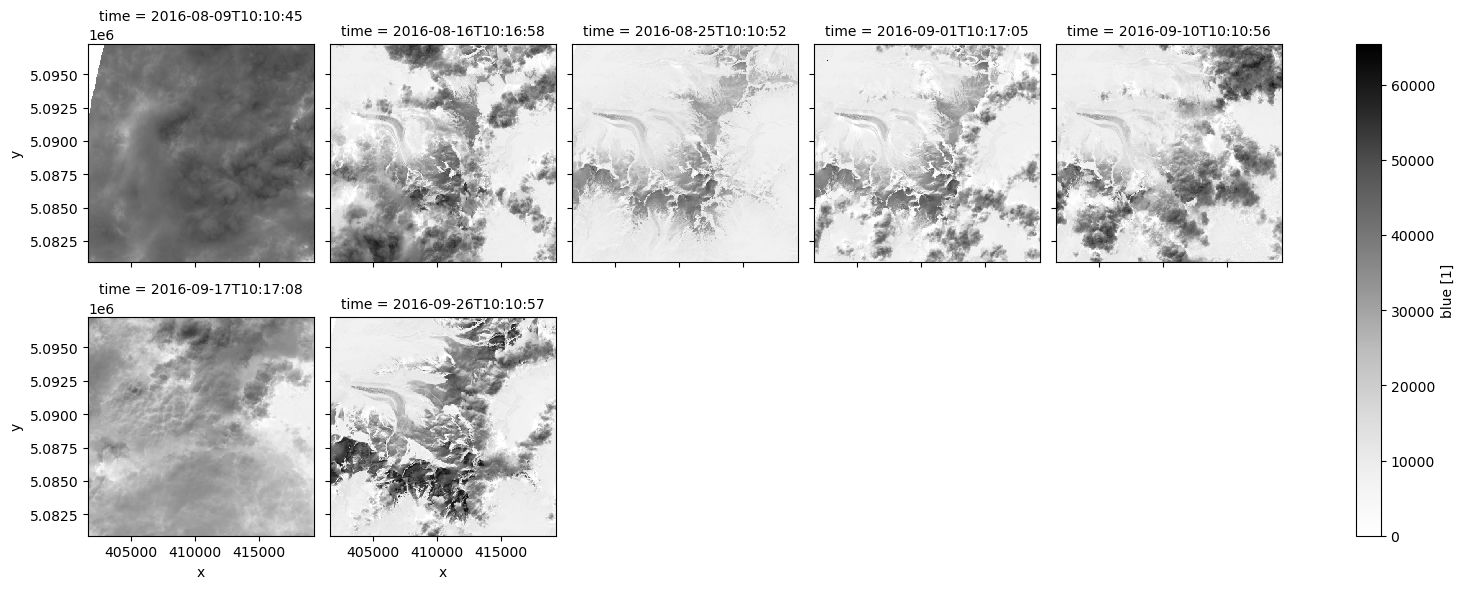

In [6]:
# plot the xarray.Dataset to get an overview of the different scenes along the time axis
dataset_in.blue.plot(col='time', col_wrap=5, cmap='Greys')

### Selecting a cloud free scene

As mentioned before, we have used the `dc.load()` function which does not mask cloud covered areas. 

<span class='dothis'>We now have to plot all time steps again and then visually define which of the scenes is cloud free.</span>

This is best done by visualizing composites, either true color or false color. In the following we first visualize the data in true color, followed by two examples of popular false color visualization for Landsat data.

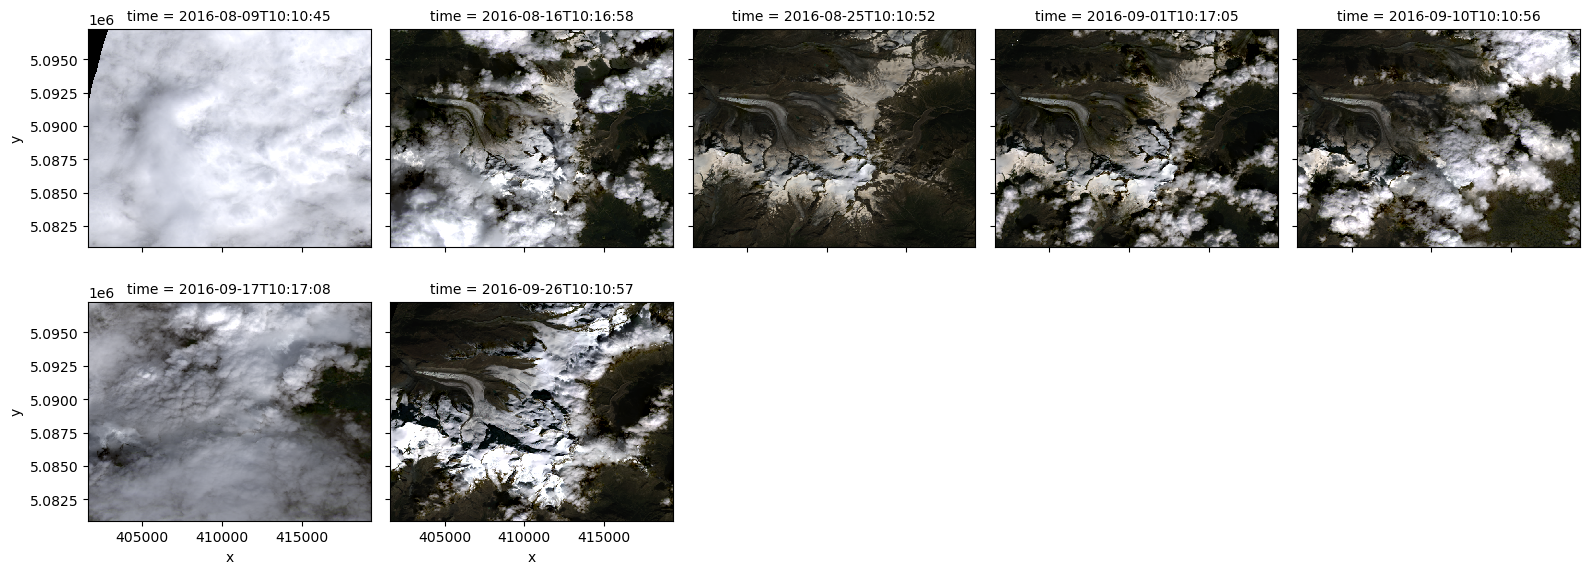

In [7]:
# Let's plot composites in True color (red, green, blue)
# robust=True guesses the minimum and maximum values for each image.
dataset_in[['red','green','blue']].to_array().plot.imshow(col='time',col_wrap=5, robust=True)

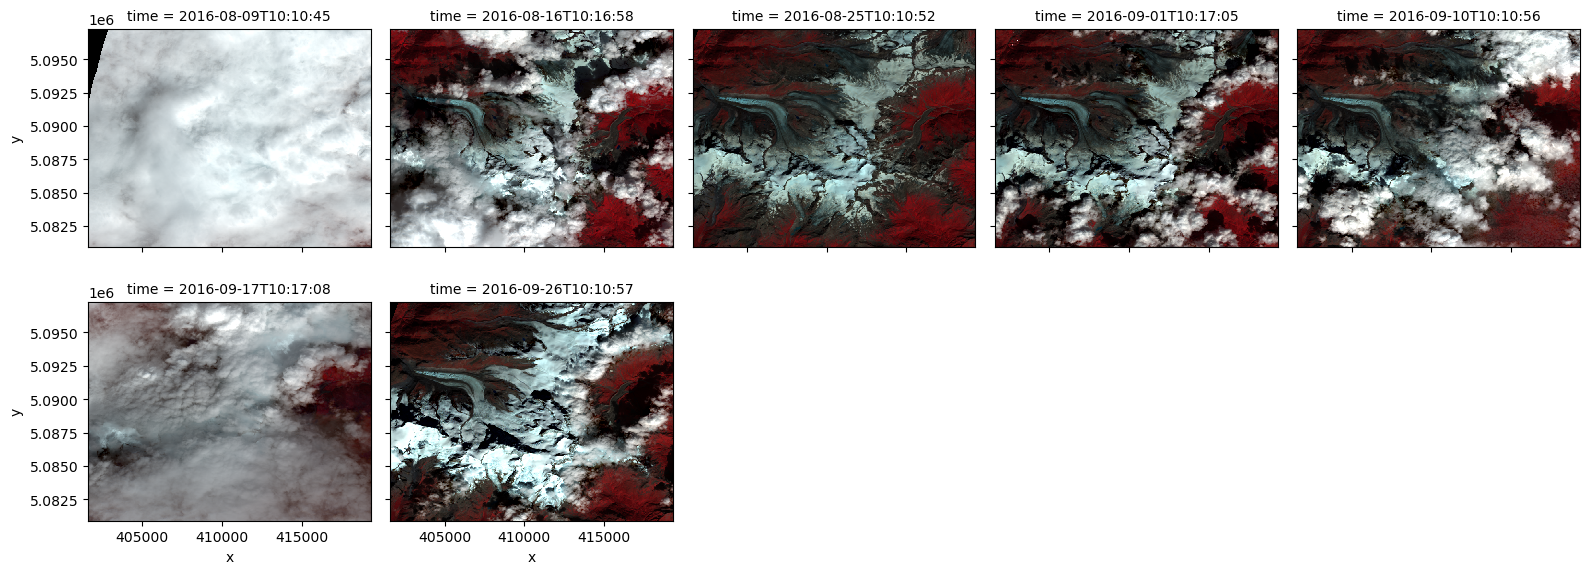

In [8]:
# Let's plot composites in False color (nir, red, green)
dataset_in[['nir','red', 'green']].to_array().plot.imshow(col='time',col_wrap=5, robust=True)

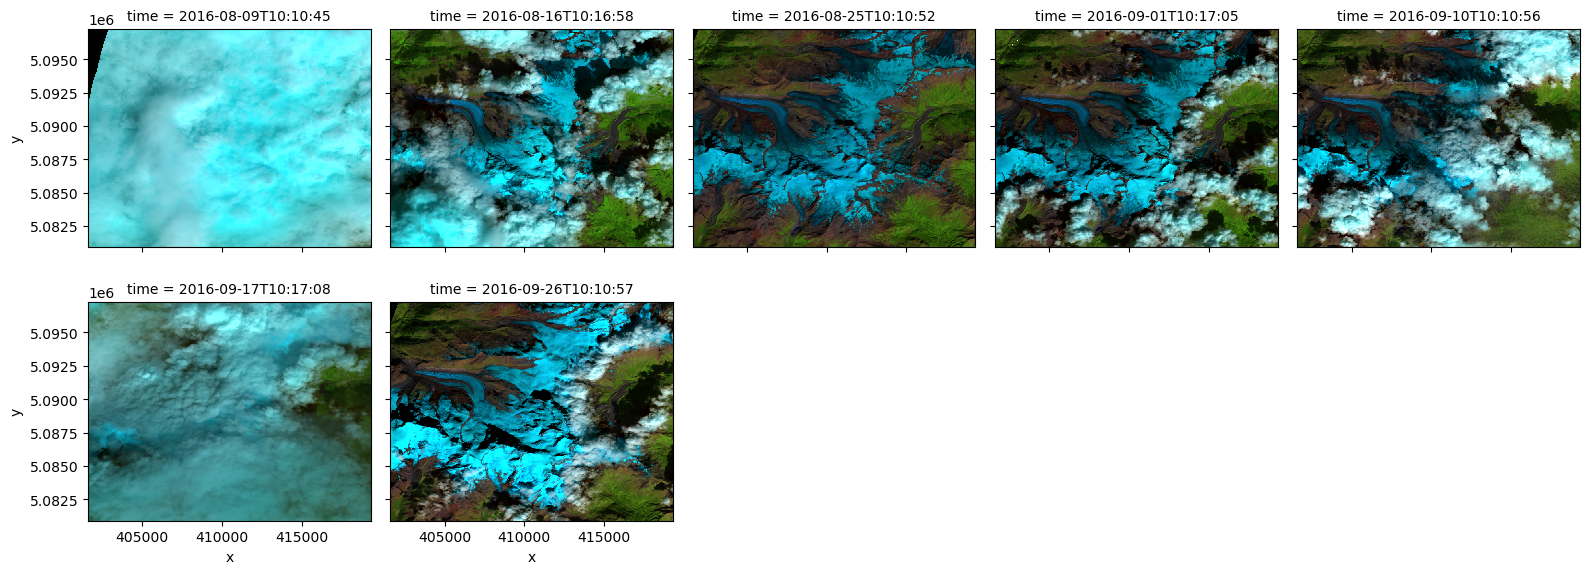

In [9]:
# Let's plot composites in another false color combination, this time (swir1, nir, red) which is well suited to see ice and snow
dataset_in[['swir_1','nir', 'red']].to_array().plot.imshow(col='time',col_wrap=5, robust=True)

Regardless of which visualization we work with, we see that from the seven scenes, only one appears cloud free: **2016-08-25T10:10:52**. We continue working only with that scene.

In [10]:
# Let's select the image we are interested in and save it to a new variable.
# To do this we provide the date of the image we selected above 
# The squeeze() command removes the time dimension from the DataArray, so you are left with two dimensions: latitude and longitude.
mosaic = dataset_in.sel(time='2016-08-25').squeeze()
mosaic

<xarray.Dataset>
Dimensions:      (y: 547, x: 590)
Coordinates:
    time         datetime64[ns] 2016-08-25T10:10:52
  * y            (y) float64 5.097e+06 5.097e+06 ... 5.081e+06 5.081e+06
  * x            (x) float64 4.016e+05 4.017e+05 ... 4.193e+05 4.193e+05
    spatial_ref  int32 32632
Data variables:
    QA_PIXEL     (y, x) uint16 1 1 1 1 1 1 ... 21824 21824 21824 21824 21824
    blue         (y, x) uint16 0 0 0 0 0 0 0 ... 9358 8904 8484 9993 10223 9738
    green        (y, x) uint16 0 0 0 0 0 0 ... 10951 10628 11859 12013 11561
    red          (y, x) uint16 0 0 0 0 0 0 ... 10953 10387 12049 12379 11986
    nir          (y, x) uint16 0 0 0 0 0 0 ... 23752 25899 20442 18582 18389
    swir_1       (y, x) uint16 0 0 0 0 0 0 ... 19360 19024 19337 19568 19238
    swir_2       (y, x) uint16 0 0 0 0 0 0 ... 14563 13584 15409 16126 15740
Attributes:
    crs:           epsg:32632
    grid_mapping:  spatial_ref

<a id='mosaic_plot'> </a>
Plot mosaic the default way.

In [ ]:

# To do this we need to provide the list of bands we are interested in.
mosaic[['red','green','blue']].to_array().plot.imshow(robust=True)
plt.gca().set_aspect('equal')

In [ ]:
mosaic

In [ ]:
# Export the red, green and blue bands of the image (might become usefuly later)
write_geotiff_from_xr(tif_path = 'glaciers.tif',
                      dataset = mosaic[['red','green','blue']].astype('int32'),
                      crs=output_crs,
                      compr = 'DEFLATE')


### Band math for glacier detection

*****

We now detect glacier surfaces using the band math: *G = Red / Swir*

Thereby a threshold needs to be defined to distinguish glaciers from non-glacierized terrain.

In [ ]:
G = mosaic.red / mosaic.swir_1

In [ ]:
G.plot()

We can faintly recognize the result but the extent of the automatically generated scale is not good. 

Probably, there are outliers which result in the automated choice of the data range. 

The easy way to visualize the data while ignoring the outliers is to pass the parameter robust=True. This will use the 2nd and 98th percentiles of the data to compute the color limits.

In [ ]:
G.plot(robust=True)

**Note how the color palette has changed.** This is simply because the `DataArray.plot()` function we are using tries to automatically define the optimal colormap. 

We can suppress this behaviour by specifying a colormap from https://matplotlib.org/stable/gallery/color/colormap_reference.html

In [ ]:
G.plot(robust=True, cmap='bwr')

Now let's try to plot the data as a histogram

In [ ]:
G.plot.hist()

This throws an error message, telling us that the data range reaches infinity. This might also explain some of our difficulties in plotting. 

<span class='dothis'>Let's address the problem by the root and remove all cells that have the value "infinte" and then try to plot the histogram again.</span>

In [ ]:
G = G.where(np.isfinite(G))  # Set all values that are not finite to NaN (Not a Number)

In [ ]:
G.plot.hist()

This works now but the results are not satisfying as we can't recognize any details. We know that the threshold is somewhere close to zero, so we would like to see the details in the vicinity of zero. 

* Let's look at the range of values in G
* Let's increase the number of bins in the histogram

In [ ]:
G.plot.hist(bins=40, range=(-50, 50))  # We added the "bin" keyword that allows specifying the number of bins to be used

This looks even better, but there is no need to visualize all the absence of data on the left-hand side. <span class='dothis'>Adjust the parameters in the plotting command above so you achieve an optimal visualization.</span>

### Selecting the threshold value for glacier mapping

Now to the actual glacier mapping. <span class='dothis'>As we did in QGIS, we will define a threshold to distinguish between glaciers (where <i>G > threshold</i>) and non-glacierized terrain (<i>G < threshold</i>).</span>

We can directly test whether the threshold is appropriate by plotting the scene, but this time telling the program to use discrete colors for all values that are within intervals that we define with the `levels` keyword. Note that we need to define at least two values for `levels`. We simply chose the first one very low, outside the range of data values.



In [ ]:
# here we set the threshold - CHANGE THIS TO VARY THE THRESHOLD!
threshold = 0

In [ ]:
# Using the "levels" keyword which allows specifying the boundaries between discrete classes for plotting. 
G.plot(levels=[-100, threshold])  # Here the resulting classes are (1) smaller -100, (2) between -100 and "threshold", (3) larger than "Trheshold"

This plot now shows all grid cell with values between -100 and "threshold" in white, all grid cells with values > threshold in red.

This is excellent, **but has the disadvantage that we have no comparison with the original scene, to be able to assess how accurately our chosen threshold distinguishes glaciers from non-glacierized terrain.**

We thus go more fancy and **plot the above threshold map *and* a false color composite of the original scene on top of each other.** We do this by simply calling the `plot()` function twice, the two graphics will then be plotted into the same figure. Furthermore, we use the `alpha` parameter to define how transparent the threshold map should be (`alpha = 0` fully transparent, `alpha = 1` fully opaque).

In [ ]:
G.plot(levels=[-100, threshold], alpha=0.3)
mosaic[['red','green','blue']].to_array().plot.imshow(robust=True)

With these tools at hand, **vary the threshold to find an optimal treshold value.**

### Basic statistics

**Now to some very basic statistics: How many percent of the chosen satellite image are glacier covered?**

We calculate this by taking the number of glacierized grid cells `(G.where(G > threshold)).count()` and divide them by the total number of grid cells `G.count()`. The result is again a xr.DataArray which contains just the value.

In [ ]:
100 * (G.where(G > threshold)).count() / G.count()

### Export the results

After we found an optimal threshold value, let's now create an array where all glacier grid cells have the value 1, and all non-glacierized cells have the value 0.

We do this by using the `xr.where()` function. Its syntax is `xr.where(condition, value to use where condition is True, value to use where condition is False)`.

In [ ]:
G

In [ ]:
glacier = xr.where(G > threshold, 1, 0)
glacier

In [ ]:
glacier.plot()  # plt it once again to see whether the result is what we want

<span class='dothis'>If everything looks fine, then it is now time to export our glacier map. We do this by using the function `rio.to_raster()`.</span>

Note that our xr.DataArray named *glacier* is of the data type `int32` (= 32 bit integer). The export function cannot handle this data type. Thus we convert *glacier* to data type `int16` (16 bit integer) during export by using `glacier.astype('int16')`.

This makes a 'GeoTIFF' file which can be loaded into software like QGIS or ArcGIS. Note that GeoTIFFs are not properly understood by programs like Photos or Photoshop, so they will look quite strange if they open at all!

In [ ]:
glacier.astype('int16').rio.to_raster("glacier_map.tif")